In [ ]:
'''Individual skills MAB'''

In [6]:
# Omid55
import numpy as np
import random as rand
import scipy.stats as stat
import math
import itertools as itt
import collections
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
%matplotlib inline

# THERE IS NO NETWORK
'''Problem class'''
'''Each person has a probability of success in
 the task and network and weight between does not matter'''


class Problem:
    # npeople
    # probabilities: [npeople,1]
    # team_size
    # optimal_team

    def __init__(self, npeople, team_size):
        self.npeople = npeople
        self.probabilities = np.random.rand(npeople)
        self.team_size = team_size
        self.compute_optimal_team()
        self.STOCHASTICITY = 0.05
        self.total_possible_teams = []

    def set_npeople(self, npeople):
        self.npeople = npeople
        self.probabilities = np.random.rand(npeople)
        self.compute_optimal_team()

    def set_team_size(self, team_size):
        self.team_size = team_size
        self.compute_optimal_team()

    def set_STOCHASTICITY(self, STOCHASTICITY):
        self.STOCHASTICITY = STOCHASTICITY

    def set_probabilities(self, probabilities):
        self.probabilities = np.array(probabilities)
        self.compute_optimal_team()

    def compute_optimal_team(self):
        v = sorted(self.probabilities, reverse=True)[self.team_size - 1]
        self.optimal_team = np.where(self.probabilities >= v)[0]

    def get_all_possible_teams(self):
        if not self.total_possible_teams:
            self.total_possible_teams = list(itt.combinations(range(0, self.npeople), self.team_size))
        return self.total_possible_teams

    def pull_arm(self, team):  # objective (fitness) function
        assert len(team) == self.team_size, 'team size should not be different than ' + self.team_size + ' .'
        prob = (1 - self.STOCHASTICITY) * self.compute_value_of_team(team) / self.compute_value_of_team(
            self.optimal_team)
        return stat.bernoulli.rvs(prob)  # stat.binom.rvs(1, prob)

    # the average of probability of team members
    def compute_value_of_team(self, team):
        v = 0
        for person in team:
            v += self.probabilities[person] / float(len(team))
        return v


'''Different methods for choosing team'''


# ground truth
def choose_optimal_team(problem, iterations):
    for it in range(iterations):
        reward = problem.pull_arm(problem.optimal_team)
        yield problem.optimal_team, reward


# methods
def choose_team_by_random(problem, iterations):
    for it in range(iterations):
        team = rand.sample(range(problem.npeople), problem.team_size)
        reward = problem.pull_arm(team)
        yield team, reward


def choose_team_by_explore_few_then_exploit(problem, iterations):  # Maximum Likelihood
    exploration_percent = 10
    exploration_count = iterations * exploration_percent / 100.0
    teams = []
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        if it < exploration_count:
            team = sorted(rand.sample(range(problem.npeople), problem.team_size))
            reward = problem.pull_arm(team)
            if reward == 1:
                S[str(team)[1:-1]] += 1
            else:
                F[str(team)[1:-1]] += 1
            yield team, reward
        else:
            if not teams:
                teams = list(set(list(S.keys()) + list(F.keys())))
            prob = [S[a] / (S[a] + F[a]) for a in teams]
            team_str = teams[np.argmax(prob)]
            team = list(map(int, team_str.split(',')))
            reward = problem.pull_arm(team)
            if reward == 1:
                S[team_str] += 1
            else:
                F[team_str] += 1
            yield team, reward

def choose_team_by_ucb(problem, iterations):
    pteams = problem.get_all_possible_teams()
    tn = len(pteams)
    assert iterations>tn, 'Number of iterations should be larger than number of teams.' + ' In fact, #iterations:' + str(iterations) + ' and #teams:' + str(tn)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for team in pteams:
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward
    for it in range(iterations-tn):
        prob = [S[str(t)[1:-1]]/float(S[str(t)[1:-1]]+F[str(t)[1:-1]]) + math.sqrt(2*math.log(it+tn)/float(S[str(t)[1:-1]]+F[str(t)[1:-1]])) for t in pteams]
        team = pteams[np.argmax(prob)]
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward

def choose_team_by_thompson_sampling(problem, iterations):
    pteams = problem.get_all_possible_teams()
    tn = len(pteams)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        sampled_params = np.zeros(tn)
        for t, team in enumerate(pteams):
            team_str = str(team)[1:-1]
            alpha = S[team_str] + 1
            beta = F[team_str] + 1
            sampled_params[t] = stat.beta.rvs(alpha, beta)
        team = pteams[np.argmax(sampled_params)]
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward

'''Since nodes have separate probability and we try to find the maximum average; thus, we can pick node by node and that makes it so fast and efficient
    instead of C(N,M) possibilities we need N.'''
def choose_team_by_ucb_with_random_variable_per_member(problem, iterations):
    # JUST FOR NOW   (JUST FOR INITIALIZATION OF UCB)
    pteams = problem.get_all_possible_teams()
    tn = len(pteams)
    assert iterations > tn, 'Number of iterations should be larger than number of teams.' + ' In fact, #iterations:' + str(
        iterations) + ' and #teams:' + str(tn)
    # JUST FOR NOW   (JUST FOR INITIALIZATION OF UCB)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for team in pteams:
        reward = problem.pull_arm(team)
        for i in team:
            if reward:
                S[i] += 1
            else:
                F[i] += 1
        yield team, reward
    for it in range(iterations - tn):
        prob = np.zeros(problem.npeople)
        for i in range(problem.npeople):
            ni = float(S[i] + F[i])
            prob[i] += S[i] / ni + math.sqrt(2 * math.log(it + tn) / ni)
        team = np.argsort(prob)[-problem.team_size:]
        reward = problem.pull_arm(team)
        for i in team:
            if reward:
                S[i] += 1
            else:
                F[i] += 1
        yield team, reward

def choose_team_by_thompson_sampling_with_random_variable_per_member(problem, iterations):
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        sampled_params = np.zeros(problem.npeople)
        for i in range(problem.npeople):
            alpha = S[i] + 1
            beta = F[i] + 1
            sampled_params[i] = stat.beta.rvs(alpha, beta)
        team = np.argsort(sampled_params)[-problem.team_size:]
        reward = problem.pull_arm(team)
        for i in team:
            if reward:
                S[i] += 1
            else:
                F[i] += 1
        yield team, reward



In [7]:
def main():
    
    auto = 1
    figure_points = 20
    runs = 10

    if auto:
        # params
        number_of_people = 10
        team_size = 4
        iterations = 5000
        probl = Problem(number_of_people, team_size)
    else:
        number_of_people = 4
        team_size = 3
        iterations = 1000
        probl = Problem(number_of_people, team_size)
        #probl.set_weights([[0,0.75,0.06,0.3,0.5], [0.75,0,0.88,0.46,0.95], [0.06,0.88,0,0.7,0.9], [0.3,0.46,0.7,0,0.02], [0.5,0.95,0.9,0.02,0]])  # comment it out to see diverse problems << CHECK HERE >>
        probl.set_weights([[0, 0.1, 0.9, 0.2], [0.1, 0, 0.2, 0.3], [0.9, 0.2, 0, 0.3],[0.2, 0.3, 0.3, 0]])
        print(probl.weights, '\n\n')

    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set_palette("Set1", 8)
    po = np.arange(iterations / figure_points, iterations + iterations / figure_points, iterations / figure_points)
    methods = [choose_optimal_team, choose_team_by_random, choose_team_by_explore_few_then_exploit, choose_team_by_ucb, choose_team_by_thompson_sampling, choose_team_by_ucb_with_random_variable_per_member, choose_team_by_thompson_sampling_with_random_variable_per_member]
    method_names = ['optimal', 'random', 'explore then exploit', 'UCB', 'Thompson', 'UCB member', 'Thompson member']
    success = pd.DataFrame(columns=['point', 'method', 'run', 'win_ratio'])
    c = 0
    for i, method in enumerate(methods):
        for run in range(runs):
            cnt = 0.0
            win = 0.0
            for team, reward in method(probl, iterations):
                if reward:
                    win += 1.0
                cnt += 1.0
                if not cnt % (iterations/figure_points):
                    success.loc[c] = [cnt, method_names[i], run, win / cnt]
                    c += 1
    ax = sns.tsplot(time='point', value='win_ratio', unit='run', condition='method', data=success)


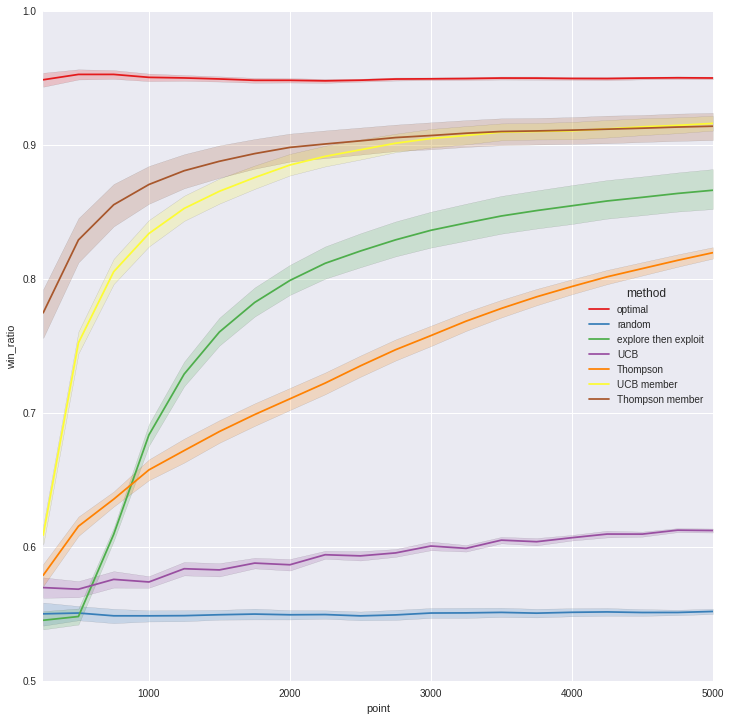

In [8]:
if __name__ == "__main__":
    main()
